<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [2]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [3]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [4]:
economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [5]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매


In [7]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [8]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [9]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

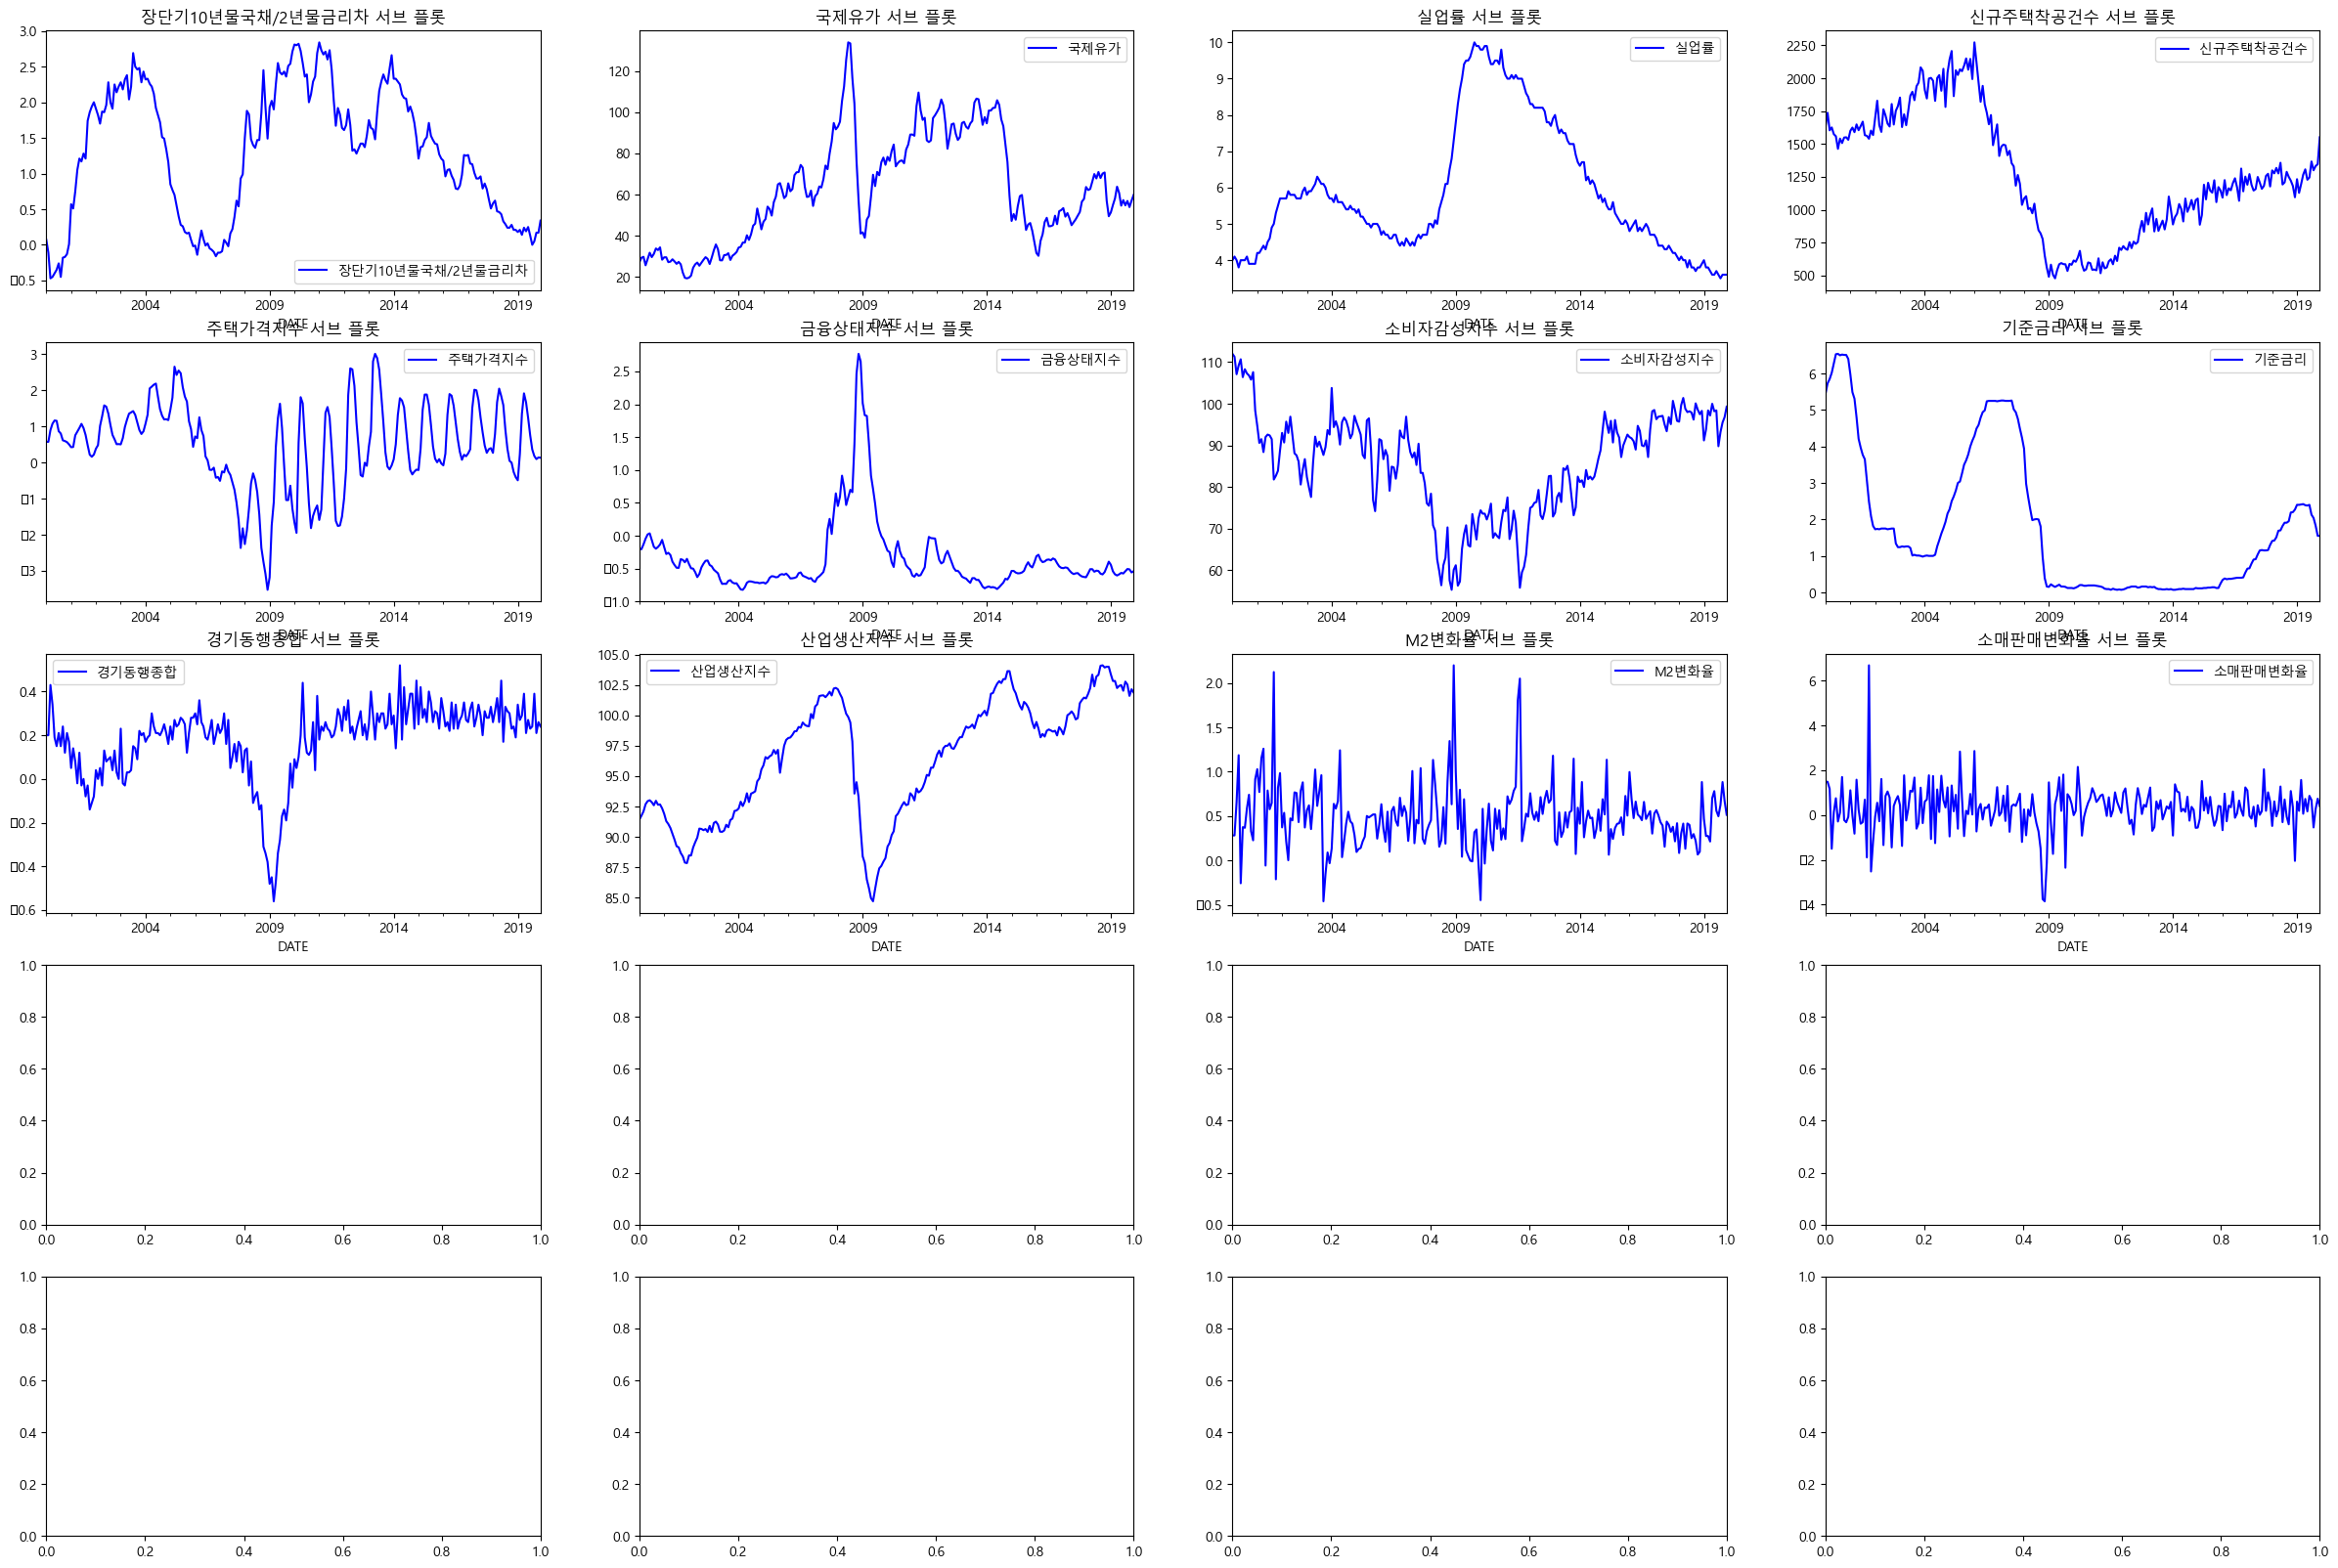

In [10]:
# 그래프 크기 조정
plt.rcParams['font.family'] ='Malgun Gothic'
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

#### StandardScaler

In [11]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
standard_scaler = StandardScaler()

# fit_transform()을 사용해서 학습과 스케일링 적용
scaled_eocs = standard_scaler.fit_transform(economics)

# 표준화가 완료된 데이터를 데이터프레임 형태 변환
scaled_eocs = pd.DataFrame(scaled_eocs,
                              index=economics.index,
                              columns=economics.columns)

scaled_eocs.head()

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,
2000-01-31,-1.358922,-1.322363,-1.041818,0.794549,0.084752,0.270843,2.143427,1.916132,0.123418,-1.022683,-0.603253,1.181786
2000-02-29,-1.556543,-1.241600,-0.986439,1.011004,0.084752,0.251169,2.086199,2.062488,0.123418,-0.959506,-0.603253,1.181786
2000-03-31,-1.951786,-1.223355,-1.041818,0.725970,0.356788,0.383517,1.742831,2.125212,1.456621,-0.886769,0.447297,0.867074
2000-04-30,-1.929828,-1.381277,-1.152576,0.773118,0.507079,0.537326,1.914515,2.214071,0.934933,-0.766660,1.926844,-1.784234
2000-05-31,-1.874933,-1.263755,-1.041818,0.663820,0.580965,0.653577,2.037146,2.344746,0.065453,-0.715037,-2.111568,-0.162329


In [16]:
scale_2 =scaled_eocs.copy()

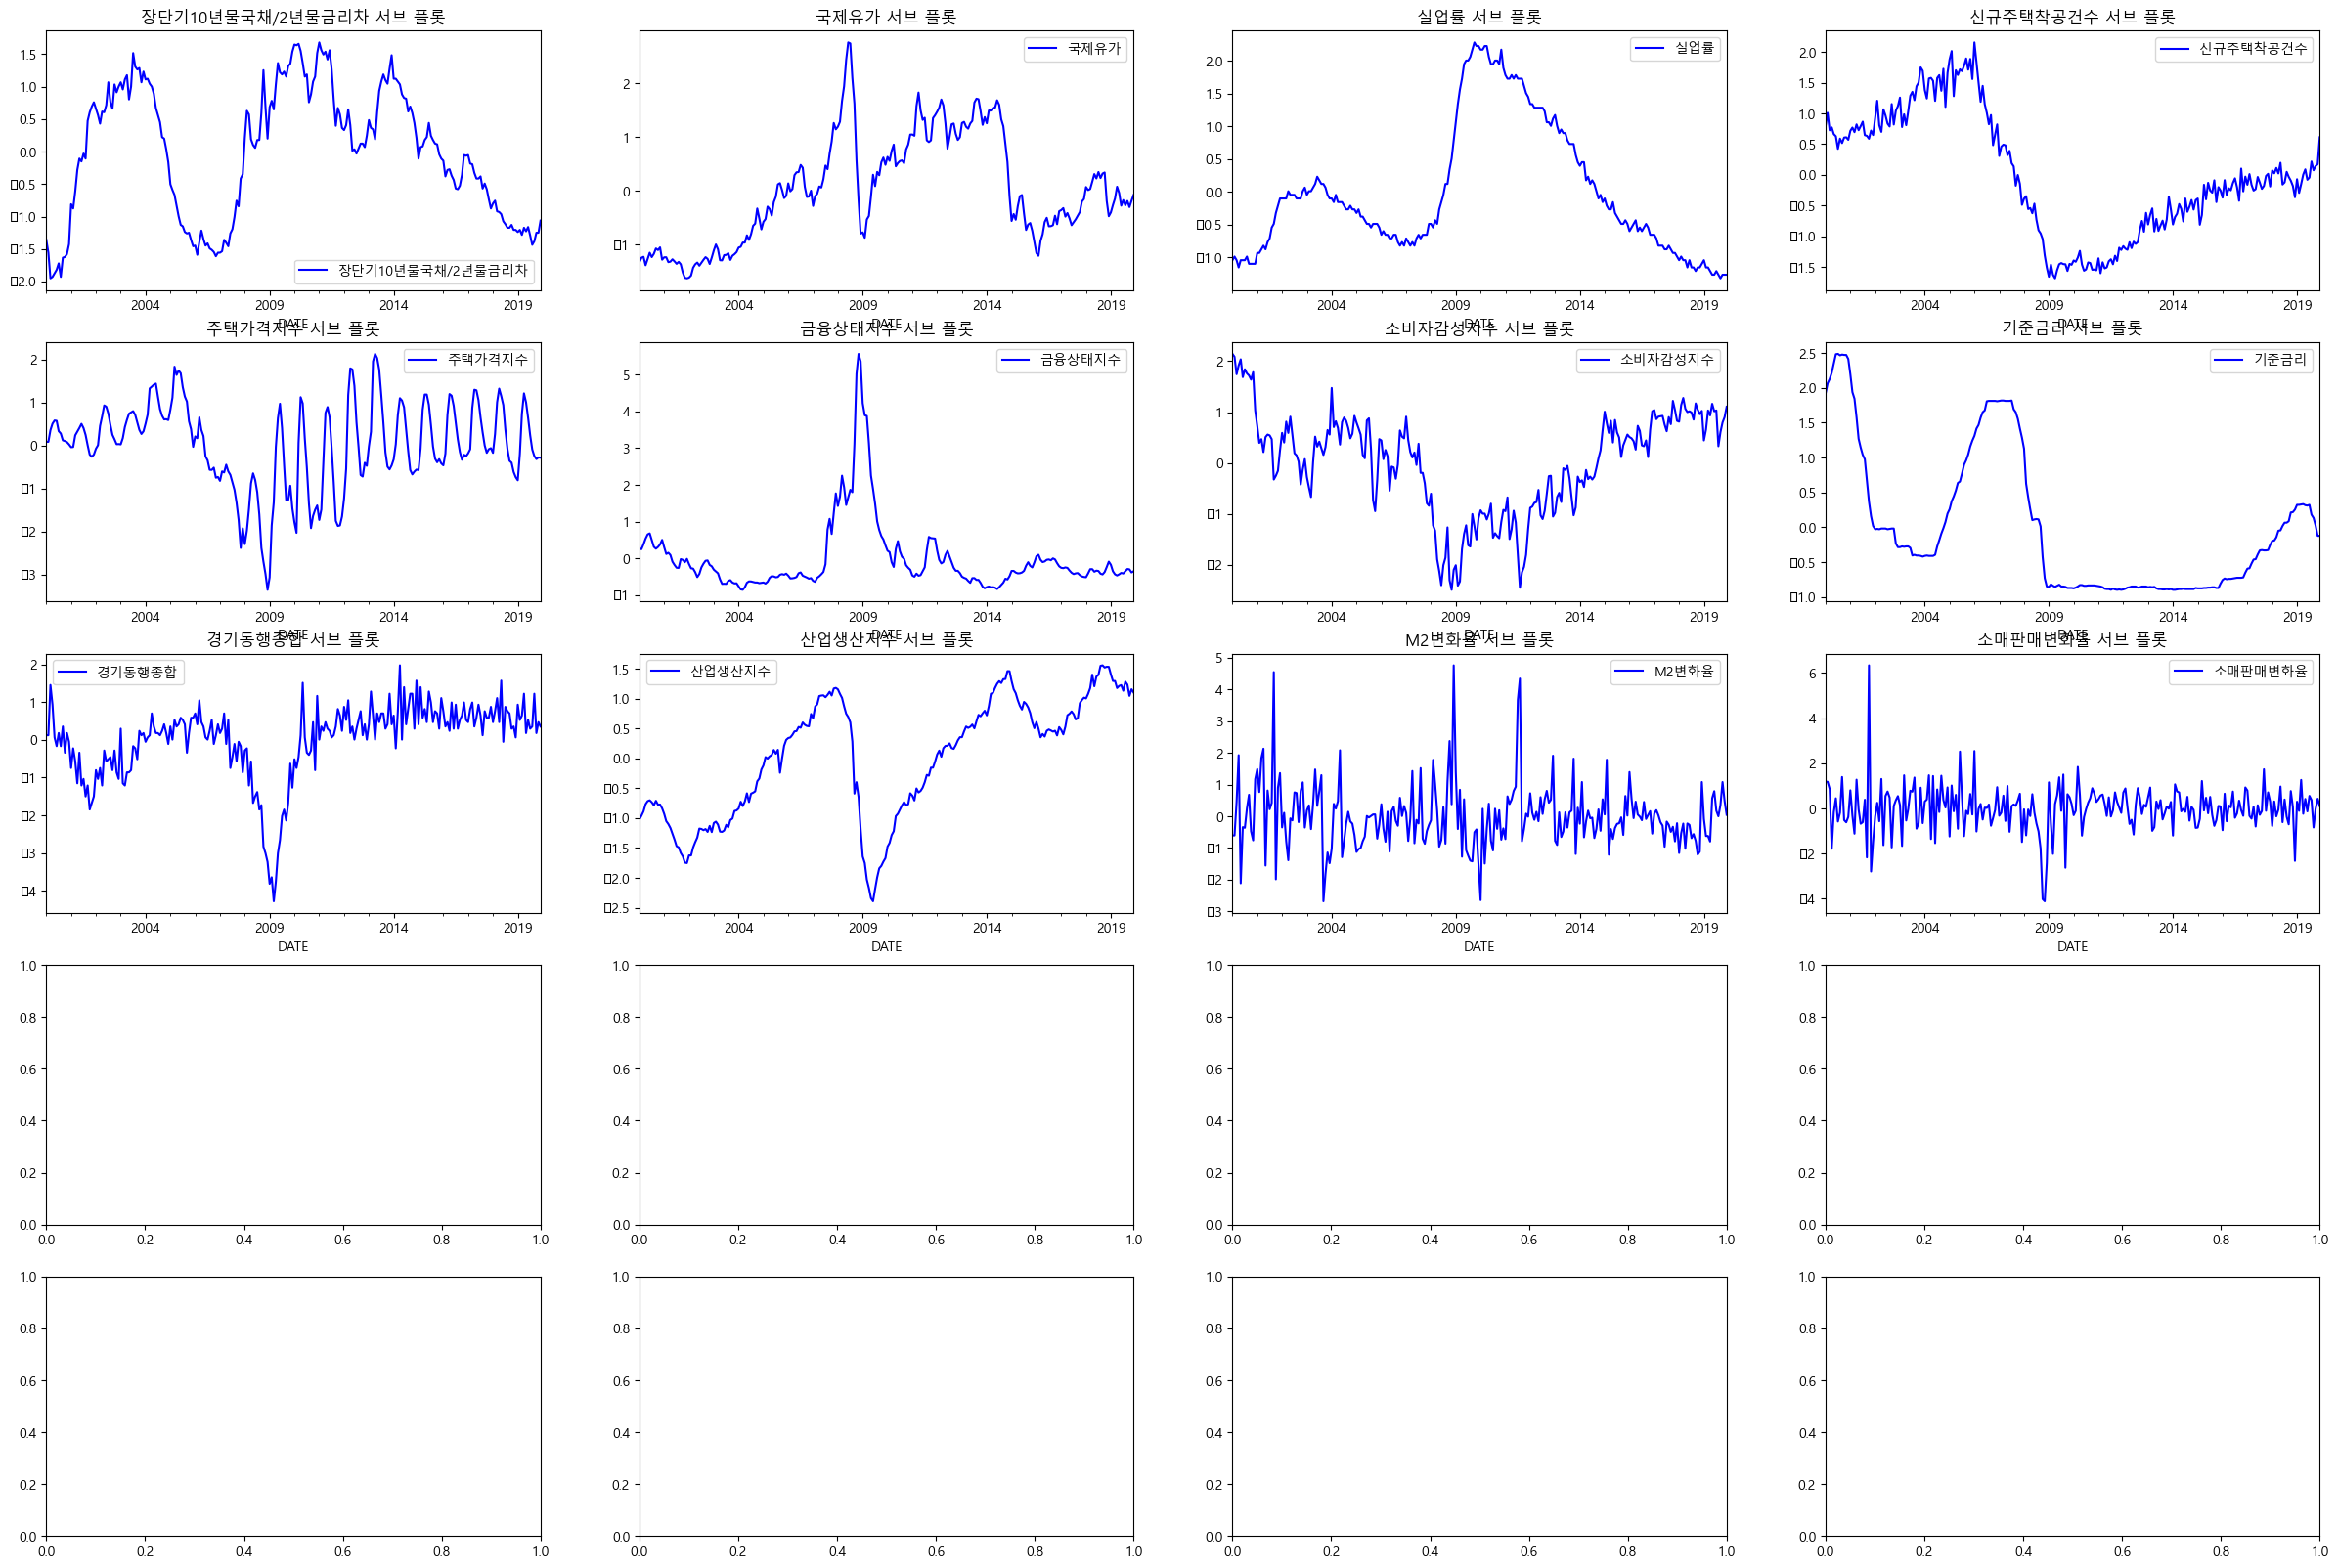

In [13]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(scaled_eocs.columns):
    scaled_eocs.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')


#### KMeans

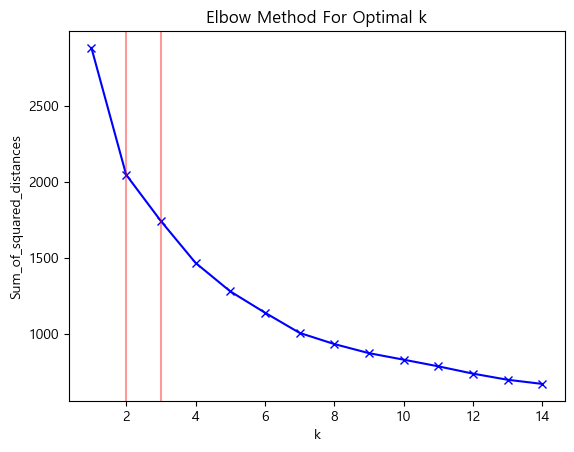

In [15]:
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(scaled_eocs) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [16]:
from sklearn.metrics import silhouette_score
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(scaled_eocs)#데이터프레임
  clusters = kmeans.predict(scaled_eocs)#데이터프레임입력

  score = silhouette_score(scaled_eocs, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )

k : 2 score : 0.31011042794861354
k : 3 score : 0.3042895113424577
k : 4 score : 0.2718776344579703
k : 5 score : 0.2681081018615722
k : 6 score : 0.27318294240232616
k : 7 score : 0.2944711431455682
k : 8 score : 0.3015880250584743
k : 9 score : 0.2853793339896672
k : 10 score : 0.2752771115469302
k : 11 score : 0.26276466854941616
k : 12 score : 0.2894828005839413
k : 13 score : 0.23222765336935483
best n : 2 best score : 0.31011042794861354


In [17]:
# k = 3 기준으로 시행

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np

# KMeans
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(scaled_eocs)

# 데이터 프레임에 cluster 추가
scaled_eocs["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(scaled_eocs, scaled_eocs.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
scaled_eocs['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(scaled_eocs, scaled_eocs.cluster)
print(f'경제데이터 Silhouette Analysis Score: {average_score:.3f}')


silhouette_samples( ) return 값의 shape: (240,)
경제데이터 Silhouette Analysis Score: 0.352


In [18]:
scaled_eocs.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.36
1,0.24
2,0.35


In [19]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

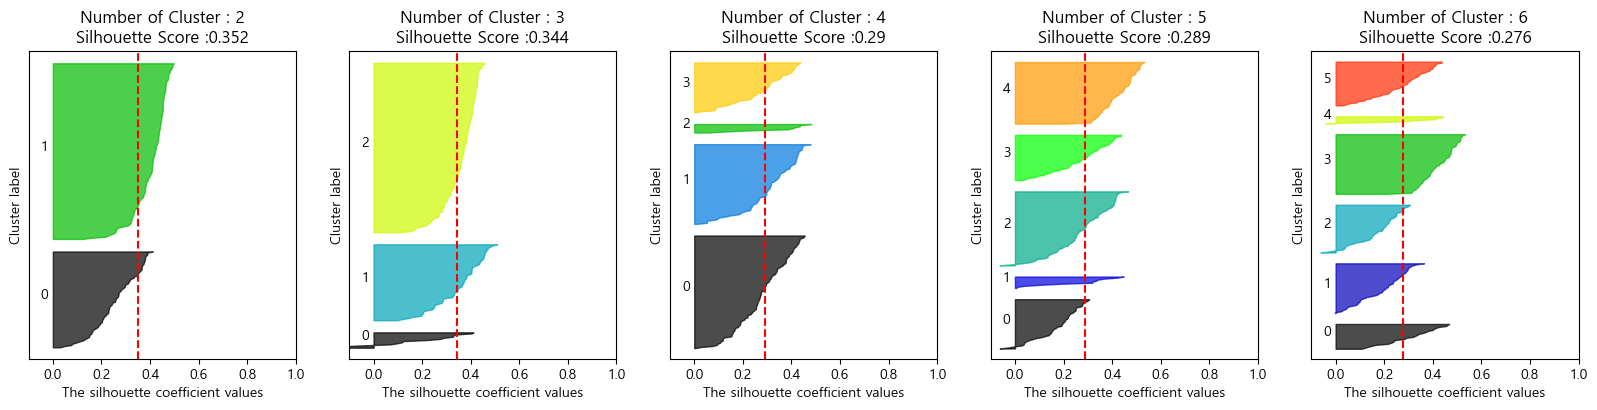

In [20]:
# 군집 개수 최적화
visualize_silhouette([ 2, 3, 4, 5 , 6], scaled_eocs)

In [21]:
# 0번 군집의 시기를 확인해봅니다.
scaled_eocs[scaled_eocs['cluster']== 0]

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
DATE,,,,,,,,,,,,,,
2000-01-31,-1.36,-1.32,-1.04,0.79,0.08,0.27,2.14,1.92,0.12,-1.02,-0.60,1.18,0,0.43
2000-02-29,-1.56,-1.24,-0.99,1.01,0.08,0.25,2.09,2.06,0.12,-0.96,-0.60,1.18,0,0.43
2000-03-31,-1.95,-1.22,-1.04,0.73,0.36,0.38,1.74,2.13,1.46,-0.89,0.45,0.87,0,0.41
2000-04-30,-1.93,-1.38,-1.15,0.77,0.51,0.54,1.91,2.21,0.93,-0.77,1.93,-1.78,0,0.36
2000-05-31,-1.87,-1.26,-1.04,0.66,0.58,0.65,2.04,2.34,0.07,-0.72,-2.11,-0.16,0,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-1.44,-0.27,-1.26,0.22,-0.09,-0.35,0.33,0.18,0.36,1.29,0.00,0.37,0,0.43
2019-09-30,-1.38,-0.18,-1.32,0.07,-0.25,-0.29,0.61,0.13,1.22,1.24,0.36,-0.84,0,0.39
2019-10-31,-1.25,-0.30,-1.26,0.14,-0.32,-0.30,0.79,0.02,0.18,1.05,1.08,-0.02,0,0.41


In [22]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(scaled_eocs['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 155개 입니다
1번째 클러스터 개수는 73개 입니다
2번째 클러스터 개수는 12개 입니다


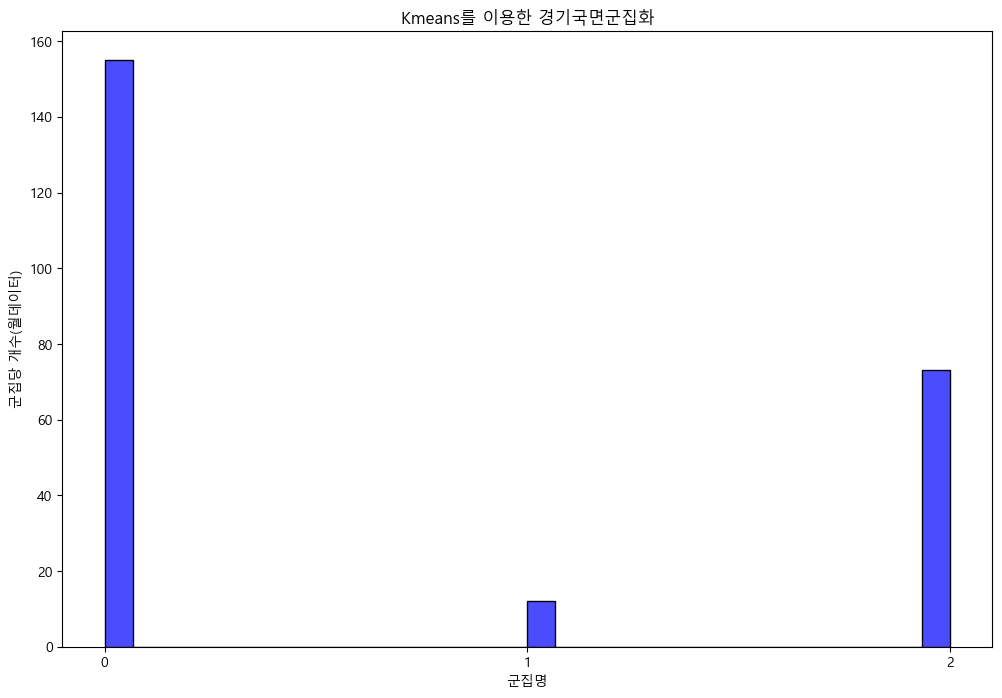

In [23]:
# k-means 군집화의 클러스터를 시각화
import matplotlib.ticker as ticker
# Seaborn 히스토그램 그리기
b=  scaled_eocs['cluster'].astype(int)


# Seaborn 히스토그램 그리기
plt.figure(figsize=(12, 8))
ax = sns.histplot(b, bins=30, kde=False, color='blue', alpha=0.7)

# x축 눈금을 정수로 바꾸는 함수
def format_func(value, tick_number):
    return int(value)

# x축 눈금에 함수 적용
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# 그래프 제목과 축 레이블 추가
plt.title('Kmeans를 이용한 경기국면군집화')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')

# 그래프 보이기
plt.show()

#### ANOVA

In [24]:
scaled_eocs['cluster'].unique()

array([0, 2, 1])

In [25]:
cluster0 = scaled_eocs[scaled_eocs['cluster']==0]
cluster1 = scaled_eocs[scaled_eocs['cluster']==1]
cluster2 = scaled_eocs[scaled_eocs['cluster']==2]

In [26]:
scale = scaled_eocs.copy()

In [27]:
scale = scale.reset_index()
scale.head()

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
0,2000-01-31,-1.36,-1.32,-1.04,0.79,0.08,0.27,2.14,1.92,0.12,-1.02,-0.60,1.18,0,0.43
1,2000-02-29,-1.56,-1.24,-0.99,1.01,0.08,0.25,2.09,2.06,0.12,-0.96,-0.60,1.18,0,0.43
2,2000-03-31,-1.95,-1.22,-1.04,0.73,0.36,0.38,1.74,2.13,1.46,-0.89,0.45,0.87,0,0.41
3,2000-04-30,-1.93,-1.38,-1.15,0.77,0.51,0.54,1.91,2.21,0.93,-0.77,1.93,-1.78,0,0.36
4,2000-05-31,-1.87,-1.26,-1.04,0.66,0.58,0.65,2.04,2.34,0.07,-0.72,-2.11,-0.16,0,0.39


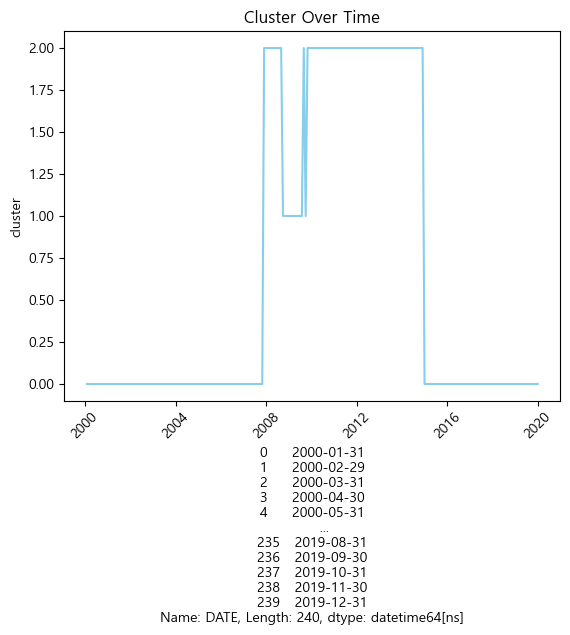

In [28]:
# 그래프 그리기
plt.plot(scale['DATE'], scale['cluster'], color='skyblue')

# 그래프 세부 설정
plt.xlabel(scale['DATE'])
plt.ylabel('cluster')
plt.title('Cluster Over Time')
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [29]:
scaled_eocs.columns

Index(['장단기10년물국채/2년물금리차', '국제유가', '실업률', '신규주택착공건수', '주택가격지수', '금융상태지수',
       '소비자감성지수', '기준금리', '경기동행종합', '산업생산지수', 'M2변화율', '소매판매변화율', 'cluster',
       'silhouette_coeff'],
      dtype='object')

In [30]:
scaled_eocs.drop(['silhouette_coeff'], axis=1,inplace=True)

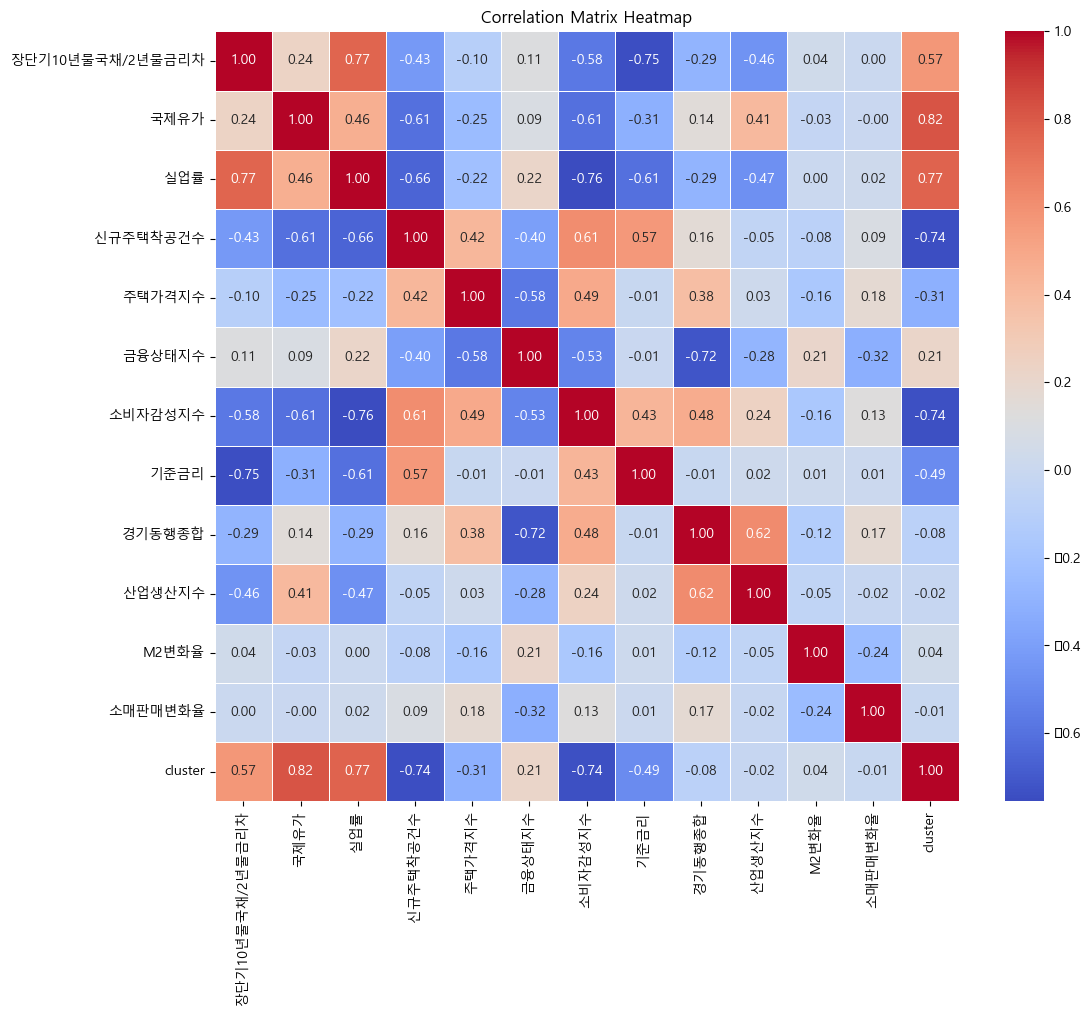

In [31]:
# 독립성 검정
import matplotlib.pyplot as plt
import seaborn as sns

# 상관 행렬 계산
correlation_matrix = scaled_eocs[scaled_eocs.columns].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [32]:
# 정규성 검정 (Shapiro-Wilk)
# 귀무가설 : 정규분포를 따른다
from scipy.stats import shapiro

# 클러스터별 feature에 대해 정규성 검정 수행
for cluster_num in range(3):  # 클러스터 번호는 0부터 2까지 총 3개
    cluster_data = scaled_eocs[scaled_eocs['cluster'] == cluster_num]
    
    print(f"\nCluster {cluster_num} - Shapiro-Wilk Test:")
    for column in cluster_data.columns:
        shapiro_test = shapiro(cluster_data[column])
        if shapiro_test.pvalue >= 0.05:
            print(f"{column} - p-value: {shapiro_test.pvalue}")


Cluster 0 - Shapiro-Wilk Test:
주택가격지수 - p-value: 0.6988344788551331
cluster - p-value: 1.0

Cluster 1 - Shapiro-Wilk Test:
장단기10년물국채/2년물금리차 - p-value: 0.3112596869468689
국제유가 - p-value: 0.19026605784893036
실업률 - p-value: 0.24256598949432373
신규주택착공건수 - p-value: 0.05772235617041588
주택가격지수 - p-value: 0.19311954081058502
금융상태지수 - p-value: 0.7796192765235901
소비자감성지수 - p-value: 0.31602412462234497
경기동행종합 - p-value: 0.8860896229743958
산업생산지수 - p-value: 0.08514472097158432
M2변화율 - p-value: 0.13022489845752716
소매판매변화율 - p-value: 0.4768083095550537
cluster - p-value: 1.0

Cluster 2 - Shapiro-Wilk Test:
소비자감성지수 - p-value: 0.1645461469888687
소매판매변화율 - p-value: 0.3219018280506134
cluster - p-value: 1.0


In [35]:
scaled_eocs2 = scaled_eocs[['주택가격지수' ,'장단기10년물국채/2년물금리차' ,'국제유가','실업률','주택가격지수' ,'소비자감성지수','산업생산지수','신규주택착공건수','금융상태지수','경기동행종합','M2변화율','소매판매변화율' ,'cluster']]

In [37]:
scaled_eocs2.head()

,주택가격지수,장단기10년물국채/2년물금리차,국제유가,실업률,주택가격지수,소비자감성지수,산업생산지수,신규주택착공건수,금융상태지수,경기동행종합,M2변화율,소매판매변화율,cluster
DATE,,,,,,,,,,,,,
2000-01-31,0.08,-1.36,-1.32,-1.04,0.08,2.14,-1.02,0.79,0.27,0.12,-0.60,1.18,0
2000-02-29,0.08,-1.56,-1.24,-0.99,0.08,2.09,-0.96,1.01,0.25,0.12,-0.60,1.18,0
2000-03-31,0.36,-1.95,-1.22,-1.04,0.36,1.74,-0.89,0.73,0.38,1.46,0.45,0.87,0
2000-04-30,0.51,-1.93,-1.38,-1.15,0.51,1.91,-0.77,0.77,0.54,0.93,1.93,-1.78,0
2000-05-31,0.58,-1.87,-1.26,-1.04,0.58,2.04,-0.72,0.66,0.65,0.07,-2.11,-0.16,0


In [38]:
cluster0 = scaled_eocs2[scaled_eocs2['cluster']==0]
cluster1 = scaled_eocs2[scaled_eocs2['cluster']==1]
cluster2 = scaled_eocs2[scaled_eocs2['cluster']==2]

In [42]:
cluster2.head()

,주택가격지수,장단기10년물국채/2년물금리차,국제유가,실업률,주택가격지수,소비자감성지수,산업생산지수,신규주택착공건수,금융상태지수,경기동행종합,M2변화율,소매판매변화율,cluster
DATE,,,,,,,,,,,,,
2007-11-30,-2.38,-0.41,1.27,-0.65,-2.38,-0.79,1.17,-0.15,1.23,-0.17,-0.47,0.65,2
2007-12-31,-1.93,-0.35,1.15,-0.49,-1.93,-0.84,1.18,-0.49,1.77,-0.86,-0.27,-1.48,2
2008-01-31,-2.29,0.21,1.20,-0.49,-2.29,-0.60,1.16,-0.39,1.43,-0.28,-0.13,-0.04,2
2008-02-29,-1.98,0.63,1.29,-0.54,-1.98,-1.22,1.08,-0.35,1.68,-0.22,1.78,-1.19,2
2008-03-31,-1.48,0.57,1.67,-0.43,-1.48,-1.33,1.01,-0.56,2.25,-1.21,1.02,-0.05,2


In [45]:
from scipy.stats import bartlett

# 등분산성 검정을 수행할 데이터프레임들
dataframes = [cluster0, cluster1, cluster2]

# 모든 데이터프레임의 행 수가 동일한지 확인
num_rows = set(df.shape[0] for df in dataframes)
if len(num_rows) != 1:
    raise ValueError("All dataframes must have the same number of rows for Bartlett's test.")

# 각 데이터프레임에 대해 등분산성 검정 수행
for i, cluster_data in enumerate(dataframes):
    print(f"\nCluster {i} - Bartlett's Test:")
    
    # 데이터프레임에서 열(column)을 반복하여 등분산성 검정 수행
    for column in cluster_data.columns:
        # 각 그룹에 대한 데이터를 리스트로 전달
        group_data = [df[column] for df in dataframes]
        
        # 등분산성 검정 수행
        bartlett_test = bartlett(*group_data)
        
        if bartlett_test.pvalue >= 0.05:
            print(f"{column} - p-value: {bartlett_test.pvalue}")

ValueError: All dataframes must have the same number of rows for Bartlett's test.

In [43]:
# 등분산성 검정 - 바틀렛검정
# 귀무가설 : 등분산성의 특징이 있다
from scipy.stats import bartlett

# 등분산성 검정을 수행할 데이터프레임들
dataframes = [cluster0, cluster1, cluster2]

# 각 데이터프레임에 대해 등분산성 검정 수행
for i, cluster_data in enumerate(dataframes):
    print(f"\nCluster {i} - Bartlett's Test:")
    for column in cluster_data.columns:
        # 등분산성 검정 수행
        bartlett_test = bartlett(*[dataframe[column] for dataframe in dataframes])
        if bartlett_test.pvalue >= 0.05:
            print(f"{column} - p-value: {bartlett_test.pvalue}")



Cluster 0 - Bartlett's Test:


ValueError: Samples must be one-dimensional.

독립성, 정규성, 등분산성 검정 후 ANOVA 수행

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import numpy as np
from statsmodels.formula.api import ols

for col in cluster0.columns:
    F, p = stats.f_oneway(cluster0[col], cluster1[col], cluster2[col])
    
    # p 값 중 하나라도 0.05 이하인지 확인
    if np.any(np.round(p, 5) <= 0.05):
        print(f"{col} \n F-통계량: {F} \n p-값: {p}")


주택가격지수 
 F-통계량: [27.19494453 27.19494453] 
 p-값: [2.33052275e-11 2.33052275e-11]
장단기10년물국채/2년물금리차 
 F-통계량: 65.05429651393216 
 p-값: 3.016649079589309e-23
국제유가 
 F-통계량: 247.86476399602344 
 p-값: 8.163028989432572e-59
실업률 
 F-통계량: 220.25255195899067 
 p-값: 8.801147638180075e-55
주택가격지수 
 F-통계량: [27.19494453 27.19494453] 
 p-값: [2.33052275e-11 2.33052275e-11]
소비자감성지수 
 F-통계량: 244.2648437153831 
 p-값: 2.6305057595891775e-58
산업생산지수 
 F-통계량: 18.401578612831365 
 p-값: 3.725825221303444e-08
신규주택착공건수 
 F-통계량: 196.3756861088478 
 p-값: 5.083209240258662e-51
금융상태지수 
 F-통계량: 195.888328516749 
 p-값: 6.107371943131792e-51
경기동행종합 
 F-통계량: 108.3832728467654 
 p-값: 3.7413714792045093e-34
소매판매변화율 
 F-통계량: 9.798025900676986 
 p-값: 8.157509636196451e-05
cluster 
 F-통계량: inf 
 p-값: 0.0


In [43]:
# 위의 피쳐들이 유의미하게 나옴